# Treinando de diferentes formas

Neste notebook vamos explorar o treino da rede da aula passada de diferentes formas e ver seu resultado como um plot das dimensões reduzidas obtidas por PCA.

Vamos avaliar os seguintes cenários:

- Rede não treinada

- Rede treinada como um classificador utilizando entropia cruzada

- Rede treinada com Triplet Loss

- Rede treinada com Constative Loss

- Rede treinada como classificador e então com Triplet Loss

- Rede treinada como classificador e então com Triplet Loss

# Rede Não Treinada

In [1]:
import tensorflow as tf

def setup_gpu(gpu_ids):

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            sel_gpus = [gpus[g] for g in gpu_ids]
            tf.config.set_visible_devices(sel_gpus, 'GPU')
            for g in sel_gpus:
                tf.config.experimental.set_memory_growth(g, True)
        except RuntimeError as e:
            # visible devices must be set before GPUs have been initialized
            print(e)
            
setup_gpu([0])

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# carregando datasets do keras
#from tensorflow.keras.datasets import mnist

from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
# obtendo informações das imagens (resolucao) e dos rótulos (número de classes)
img_lin, img_col = x_train.shape[1], x_train.shape[2]
if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]
        
num_classes = len(np.unique(y_train))
print(x_train.shape)
print('Classes: ', num_classes)

# dividir por 255 para obter normalizacao
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# transformar categorias em one-hot-encoding
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

# formatar para treinamento
x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)

# formato da entrada
input_shape = (img_lin, img_col, n_channels)
print('Tamanho da entrada: ', input_shape)

(60000, 28, 28)
Classes:  10
Tamanho da entrada:  (28, 28, 1)


In [5]:
# vamos criar um índice do mnist para facilitar o acesso a cada classe
indexed_mnist = [[],[],[],[],[],[],[],[],[],[]]

for x, y in zip(x_train, y_train):
  #print(y)
  indexed_mnist[y].append(x)
  #break



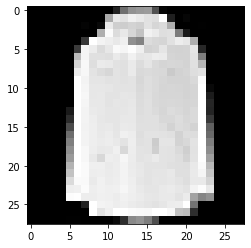

In [12]:
plt.imshow(indexed_mnist[4][10][:,:,0],cmap='gray')

In [13]:
# para acelerar e facilitar o código podemos criar um indice para as classes negativas
negative_class_index = [[]]*10
for c in range(10):
    negative_class_index[c] = list(range(10))
    negative_class_index[c].remove(c)   

negative_class_index 

[[1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [14]:


import random

# vamos criar um iterador para o caso da perda constrativa
# ele deve pegar a cada iteração um exemplo para ser positivo e um negativo
def contrastive_iterator():
    i = 0
    while True:
        i += 1

        if( i> 10000):
          break
        
        # definindo nossa âncora
        idx = random.randint(0, len(x_train)-1)
        x, y = x_train[idx], y_train[idx]
        
        # para os pares vamos utilizar um exemplo negativo   
        if i % 2 == 0:
            random_negative_class = random.choice(negative_class_index[y])
            x_n = random.choice(indexed_mnist[random_negative_class])
            yield x, x_n, 1

        # com os ímpares um exemplo positivo
        if i % 2 != 0:
            x_p = random.choice(indexed_mnist[y])
            yield x, x_p, 0



In [15]:
# criamos um dataset tf a partir do nosso iterador
dataset_contrastive = tf.data.Dataset.from_generator(
    contrastive_iterator, 
    output_signature=(tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(), dtype=tf.int32))
)

In [16]:
# vamos preparar o dataset de teste
dataset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test), 
                                    tf.data.Dataset.from_tensor_slices(y_test)))

In [17]:
# Convolucional com 32 filtros 3x3 e strides (2,2), sem zero pading, ativação relu
# Convolucional com 64 filtros 3x3 e strides (2,2), sem zero pading, ativação relu
# Convolucional com 64 filtros 3x3 e strides (2,2), sem zero pading, ativação relu
# Densa com 64 neurônios e ativação relu (embedding)
# Dropout 0.25
# Densa softmax com 10 neurônios
def make_our_network(input_shape):
    x_input = tf.keras.Input(input_shape)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='valid', activation='relu')(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='valid', activation='relu')(x)    
    x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='valid', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    z_embedding = tf.keras.layers.Dense(64, activation='relu')(x)
    z = tf.keras.layers.Dropout(0.25)(z_embedding)
    z = tf.keras.layers.Dense(10, activation='softmax')(z)
    
    model_for_embedding = tf.keras.Model(x_input, z_embedding)
    model_for_classification = tf.keras.Model(x_input, z)
    return model_for_embedding, model_for_classification

In [18]:
encoder_model, classification_model = make_our_network(input_shape)

In [19]:
import numpy as np



# let's apply the network to the test set and check how it looks
def evaluate(encoder):
    all_reps, all_ys = [], []
    for x, y in dataset_test.batch(32):
        rep = encoder(x)
        all_reps.append(rep)
        all_ys.append(y)

    all_reps = np.concatenate(all_reps, axis=0)
    all_ys = np.concatenate(all_ys, axis=0)
    return all_reps, all_ys
all_reps, all_ys = evaluate(encoder_model)

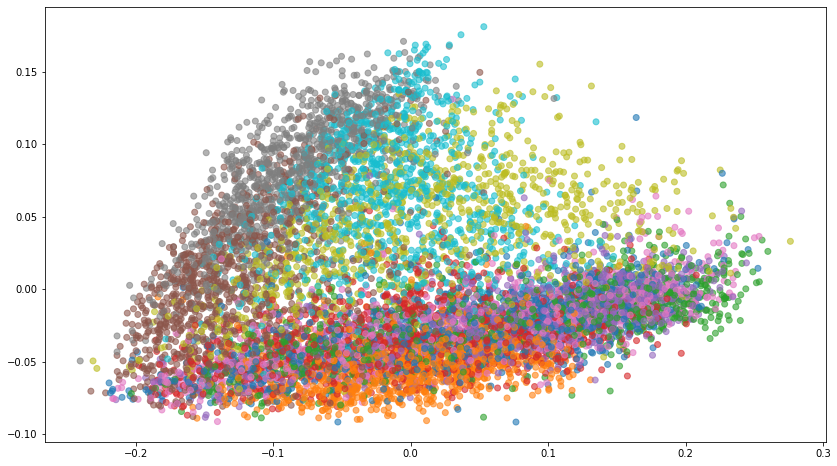

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.cm as cm
%matplotlib inline

# and plot using PCA
def visualisation(all_reps, all_ys, n_to_plot=1000):

    idx = np.random.permutation(len(all_reps))[:n_to_plot]
    all_reps = all_reps[idx]

    pca = PCA(n_components=2)
    pca.fit(all_reps)
    pca_result = pca.transform(all_reps)

    cmapper = cm.ScalarMappable(cmap=cm.tab10)
    mapped_colors = cmapper.to_rgba(all_ys[idx])

    plt.figure(figsize=(14, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=mapped_colors, alpha=0.6)
visualisation(all_reps, all_ys, n_to_plot=10000)

# Rede Treinada como Classificador (monitoria passada)

In [21]:
classification_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
history = classification_model.fit(x_train[:10000], y_train_one_hot[:10000], epochs=20, batch_size=32)

Epoch 1/20
313/313 [==============================] - 3s 6ms/step - loss: 0.9525
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 0.6011
Epoch 3/20
313/313 [==============================] - 2s 5ms/step - loss: 0.5300
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4765
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4422
Epoch 6/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4053
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3821
Epoch 8/20
313/313 [==============================] - 2s 5ms/step - loss: 0.3585
Epoch 9/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3361
Epoch 10/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3144
Epoch 11/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3016
Epoch 12/20
313/313 [==============================] - 2s 6ms/step - loss: 0.2782
Epoch 13/20
313/313 [====

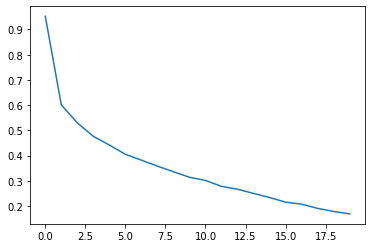

In [23]:
plt.plot(range(len(history.history['loss'])),history.history['loss'])

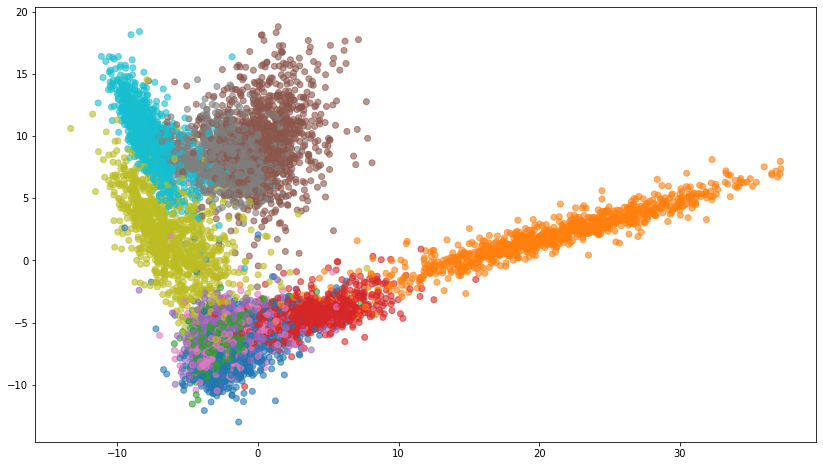

In [24]:
all_reps, all_ys = evaluate(encoder_model)
visualisation(all_reps,all_ys,n_to_plot=10000)

# Treinando Com a Constrative

In [25]:
def euclidean_distance(a, b):
    sum_squared = tf.reduce_sum(tf.square(a - b), axis=1)
    return tf.sqrt(tf.maximum(sum_squared, tf.keras.backend.epsilon()))

def make_contrastive_loss(margin=0.5):
    def contrastive_loss(a_rep, b_rep, sim_label):
        
        dis = euclidean_distance(a_rep, b_rep)
        d_p = tf.square(dis)
        d_n = tf.square(tf.maximum(0., margin - dis))
        
        sim_label = tf.cast(sim_label, tf.float32)[..., None]
        loss = (0.5)*(1 - sim_label)*d_p + (0.5)*sim_label*d_n
        return tf.reduce_mean(loss)
    return contrastive_loss

our_contrastive = make_contrastive_loss(margin=1.)

In [26]:
optimiser = tf.keras.optimizers.Adam()

In [27]:
@tf.function
def train(x_as, x_bs, ys):
    with tf.GradientTape() as tape:
        a_reps = encoder_model(x_as)
        b_reps = encoder_model(x_bs)
        loss = our_contrastive(a_reps, b_reps, ys)

    optimiser.apply_gradients(
        zip(tape.gradient(loss, encoder_model.trainable_variables), encoder_model.trainable_variables))
    return loss

In [28]:
#redefinindo os modelos
encoder_model, classification_model = make_our_network(input_shape)

In [29]:
history_loss = []
for i in range(20):
  for x_as, x_bs, ys in dataset_contrastive.batch(32):
    loss = train(x_as, x_bs, ys)
  history_loss.append(loss)

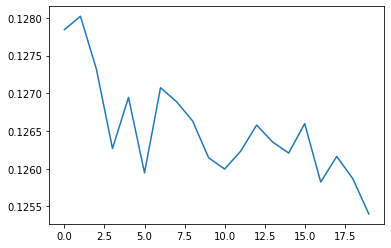

In [30]:
plt.plot(range(len(history_loss)),history_loss)

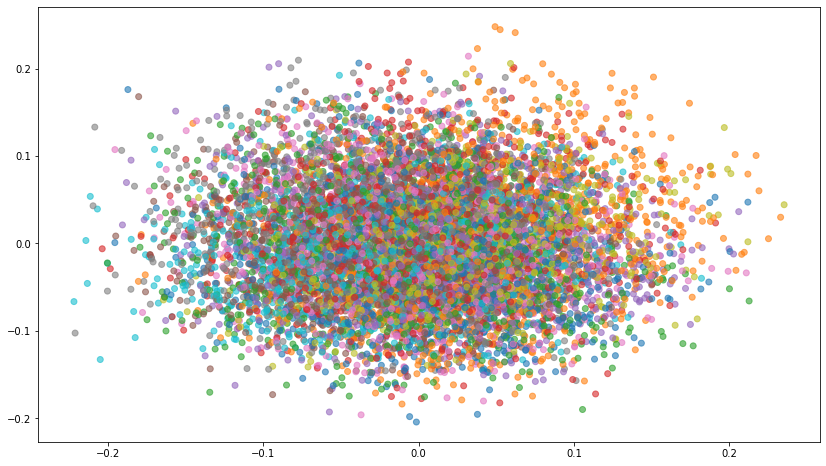

In [31]:
all_reps, all_ys = evaluate(encoder_model)
visualisation(all_reps,all_ys,n_to_plot=10000)

# Treinando Primeiro como classificador e então com a constrative loss

In [32]:
#redefinindo os modelos
encoder_model, classification_model = make_our_network(input_shape)

In [33]:
classification_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
history = classification_model.fit(x_train[:10000], y_train_one_hot[:10000], epochs=20, batch_size=32)

Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 0.9498
Epoch 2/20
313/313 [==============================] - 2s 5ms/step - loss: 0.6065
Epoch 3/20
313/313 [==============================] - 2s 5ms/step - loss: 0.5336
Epoch 4/20
313/313 [==============================] - 2s 5ms/step - loss: 0.4853
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4510
Epoch 6/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4189
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3896
Epoch 8/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3731
Epoch 9/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3470
Epoch 10/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3269
Epoch 11/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3075
Epoch 12/20
313/313 [==============================] - 2s 5ms/step - loss: 0.2881
Epoch 13/20
313/313 [====

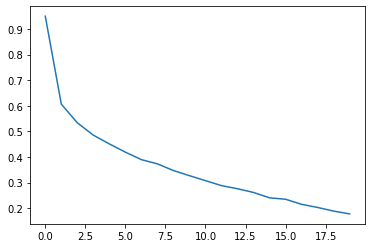

In [35]:
plt.plot(range(len(history.history['loss'])),history.history['loss'])

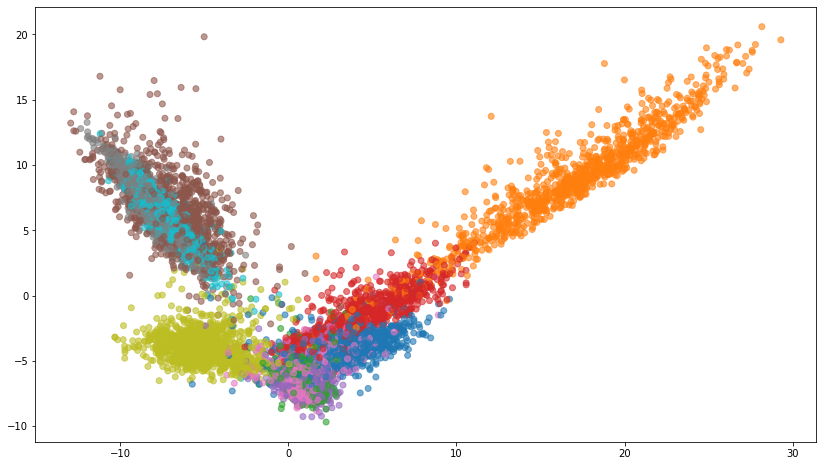

In [36]:
all_reps, all_ys = evaluate(encoder_model)
visualisation(all_reps,all_ys,n_to_plot=10000)

In [37]:
history_loss = []
for i in range(20):
  for x_as, x_bs, ys in dataset_contrastive.batch(32):
    loss = train(x_as, x_bs, ys)
  history_loss.append(loss)
  

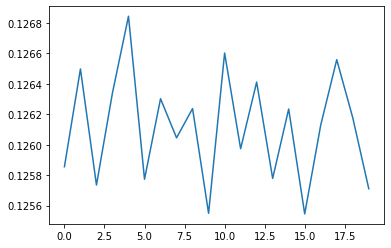

In [38]:
plt.plot(range(len(history_loss)),history_loss)

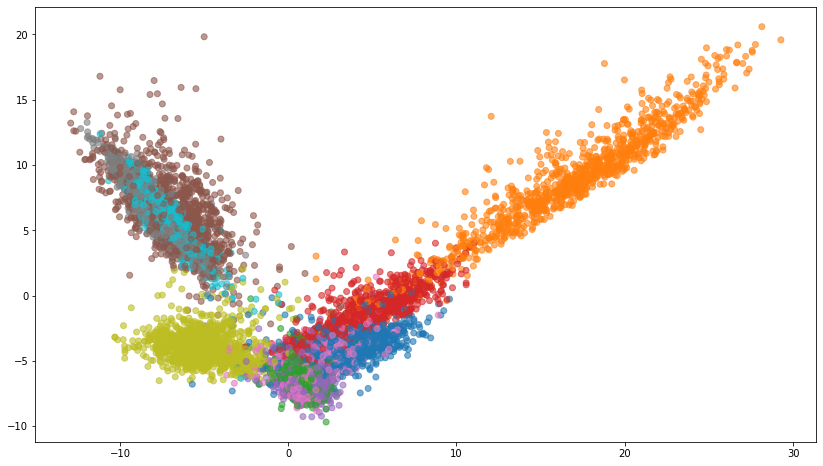

In [39]:
all_reps, all_ys = evaluate(encoder_model)
visualisation(all_reps,all_ys,n_to_plot=10000)

# Treinando apenas com a triplet

In [40]:
def triplet_iterator():
    counter = 0

    while True:
        counter +=1

        if counter > 10000:
          break
        
        idx = random.randint(0, len(x_train)-1)
        x, y = x_train[idx], y_train[idx]


        
        random_negative_class = random.choice(negative_class_index[y])
        x_n = random.choice(indexed_mnist[random_negative_class])
        
        x_p = random.choice(indexed_mnist[y])
        
        yield x, x_p, x_n


dataset_triplet = tf.data.Dataset.from_generator(
    triplet_iterator, 
    output_signature=(tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32))
)

In [41]:
encoder_model, classification_model = make_our_network(input_shape)

In [42]:
def make_triplet_loss(margin=0.5):
    def triplet_loss(a_rep, p_rep, n_rep):
        
        d_p = euclidean_distance(a_rep, p_rep)
        d_n = euclidean_distance(a_rep, n_rep)

        loss = tf.maximum(0., margin + d_p - d_n)

        return tf.reduce_mean(loss)
    return triplet_loss

our_triplet = make_triplet_loss(margin=0.5)

In [43]:
@tf.function
def train(x_as, x_ps, x_ns):
    with tf.GradientTape() as tape:
        a_reps = encoder_model(x_as)
        p_reps = encoder_model(x_ps)
        n_reps = encoder_model(x_ns)
        loss = our_triplet(a_reps, p_reps, n_reps)

    optimiser.apply_gradients(
        zip(tape.gradient(loss, encoder_model.trainable_variables), encoder_model.trainable_variables))
    return loss

In [44]:
history_loss = []
for i in range(20):
  for x_as, x_ps, x_ns in dataset_triplet.batch(32):
    loss = train(x_as, x_ps, x_ns)
  history_loss.append(loss)

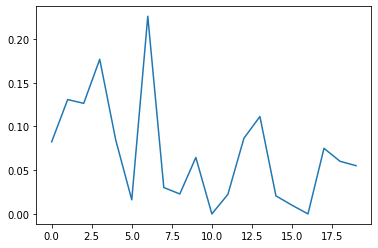

In [45]:
plt.plot(range(len(history_loss)),history_loss)

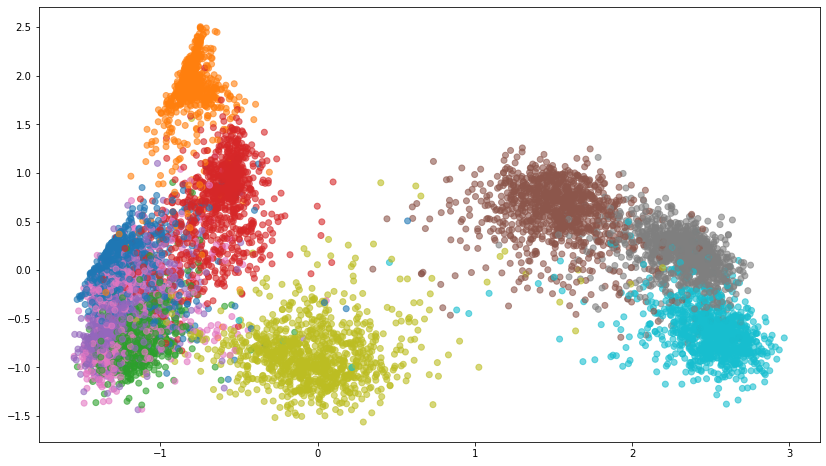

In [46]:
all_reps, all_ys = evaluate(encoder_model)
visualisation(all_reps,all_ys,n_to_plot=10000)

# Treino Misto

In [47]:
#redefinindo os modelos
encoder_model, classification_model = make_our_network(input_shape)

In [48]:
classification_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [49]:
history = classification_model.fit(x_train[:10000], y_train_one_hot[:10000], epochs=20, batch_size=32)

Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 0.9493
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 0.5997
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 0.5176
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4597
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 0.4300
Epoch 6/20
313/313 [==============================] - 2s 5ms/step - loss: 0.3898
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3668
Epoch 8/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3488
Epoch 9/20
313/313 [==============================] - 2s 6ms/step - loss: 0.3254
Epoch 10/20
313/313 [==============================] - 2s 5ms/step - loss: 0.3083
Epoch 11/20
313/313 [==============================] - 2s 6ms/step - loss: 0.2948
Epoch 12/20
313/313 [==============================] - 2s 5ms/step - loss: 0.2683
Epoch 13/20
313/313 [====

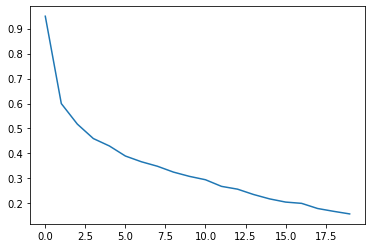

In [50]:
plt.plot(range(len(history.history['loss'])),history.history['loss'])

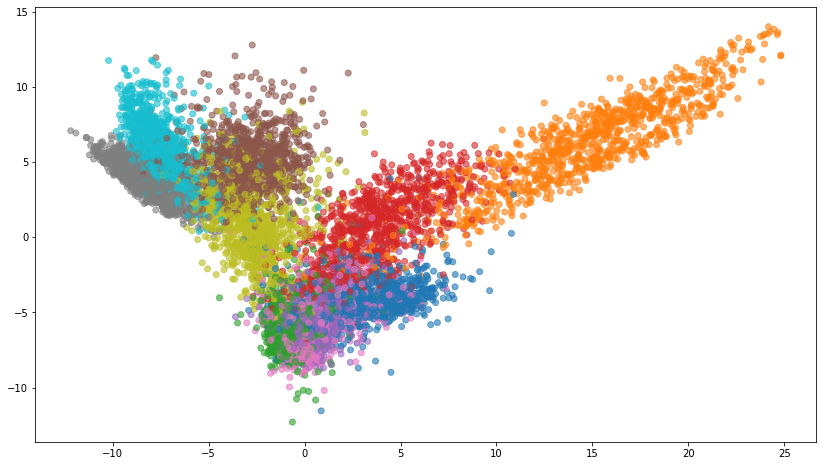

In [51]:
all_reps, all_ys = evaluate(encoder_model)
visualisation(all_reps,all_ys,n_to_plot=10000)

In [52]:
history_loss = []
for i in range(20):
  for x_as, x_ps, x_ns in dataset_triplet.batch(32):
    loss = train(x_as, x_ps, x_ns)
  history_loss.append(loss)

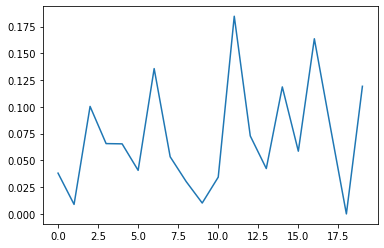

In [53]:
plt.plot(range(len(history_loss)),history_loss)

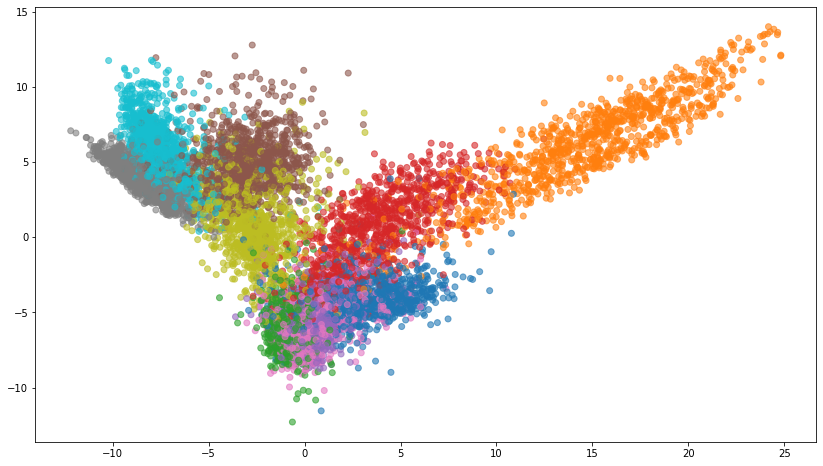

In [54]:
all_reps, all_ys = evaluate(encoder_model)
visualisation(all_reps,all_ys,n_to_plot=10000)